# Capstone Project - The best place for a beer shop
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Last weekend I met my old friend from Moscow (capital of Russian Federation). That evening was amazing we haven’t met for three years. We talked some hours about our jobs, personal file and ideas about our future plans. Eventually he told me that he wants to start his own business. His choose is some strange for me because his is an engineer and wants to open a **beer shop**. 

I decided to help him by using data science power.  

The city has a lot of districts. These are so different to start his own business. I try to find the best location for the new shop in accordance with my customer requirements and characteristics of urban areas.

## Data <a name="data"></a>

According to all the requirements. I collected a lot of data. The data is separated by categories
 - Data is represented on the official web sites and well formated.
 - Data from open sources (like Wikipedia)
 - GEO Data (retrived by some web services)  
 
Some data is not complited and has to be corrected.  
Folowing by all the data we will try to extract payload information and aggregate it to Pandas DataFrames.  

Most of our data will be collected by Yandex web service (the best service in the observed city). Also we collected data from Foursquare database.  

At the end of this section we collect all the data in one big DataFrame. It'll be suitable to explore the city clusters

#### Import libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import requests
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
import requests
import json
import io
import os
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-whitegrid')

#### Parce Wiki page and extract Moscow districts

My IP was banned by Wiki because i've done too many queries so i saved this page to 'data' folder and parced it locally

In [2]:
wiki_districts_file = './data/wiki/districts.html'
with open(wiki_districts_file,'r', encoding='utf8') as f:
    soup = BeautifulSoup(f.read(), 'html.parser')

In [3]:
tables = soup.findAll('table')
table = None
for t in tables:
    th_list = set(th.text.rstrip().upper() for th in t.findAll('th'))
    if len(th_list & {'ФЛАГ', 'ГЕРБ'}) == 2:
        table = t
        break;
if table is None:
    raise RuntimeError("Can not obtain table!")

In [4]:
df_districts = pd.read_html(str(table))[0]
df_districts.drop(df_districts.columns[[0,1,2,3,6,8,9,10]], axis=1, inplace=True)
df_districts.columns = ['DistictName', 'Borough', 'ResTotalCount']
df_districts['ResTotalCount'] = df_districts['ResTotalCount'].str.replace('↗', '', regex=True). \
    str.replace('\xa0', '', regex=True).astype(int)
df_districts.head()

,DistictName,Borough,ResTotalCount
0,Академический,ЮЗАО,109231
1,Алексеевский,СВАО,80391
2,Алтуфьевский,СВАО,57408
3,Арбат,ЦАО,35529
4,Аэропорт,САО,79294


#### Get Districts GEO points (russian map service Yandex)

Load API keys from file

In [5]:
with open('../../key.json', 'r') as f:
        cl = json.load(f)
y_api_1 = cl['y_api_1']
y_api_key = cl['y_api_key']
CLIENT_ID = cl['CLIENT_ID'] 
CLIENT_SECRET =  cl['CLIENT_SECRET']  
VERSION = '20180605' # Foursquare API version

if file already exists we don't use webservice again

In [6]:
file_name = 'data/json_geo_district.json'
if not os.path.exists(file_name):
    print('collection data....')
    coords = []
    for d_name in df_districts.iterrows():
        name = d_name[1].DistictName
        bor = d_name[1].Borough
        tcount = d_name[1].ResTotalCount
        s = 'Москва,' + d_name[1].DistictName + ' район'
        resp = requests.get('https://geocode-maps.yandex.ru/1.x/?apikey='+y_api_key+'&format=json&geocode=' + s)
        resp.encoding = 'utf-8'
        jpayload = json.loads(resp.text)
        coords.append({name:{'data':jpayload,'borough':bor, 'ResTotalCount': tcount}})
    with io.open(file_name, 'w', encoding='utf8') as json_file:
        json.dump(coords, json_file, ensure_ascii=False)
else:
    print('file exists')
    with io.open(file_name, 'r', encoding='utf8') as json_file:
        coords = json.loads(json_file.read())

file exists


Get coordinates of all districts centers

In [7]:
district_coords = []
for item in coords:
    for key,val in item.items():
        #print(key)
        cor = val['data']['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split(' ')
        bor = val['borough']
        rc = val['ResTotalCount']
        #print(cor)
        district_coords.append([key, rc, bor, cor[1], cor[0]])

In [8]:
df_districts_coords = pd.DataFrame(district_coords)
df_districts_coords.columns = ['DistrictName', 'ResTotalCount', 'Borough', 'lat', 'lng']
df_districts_coords['lat'] = df_districts_coords['lat'].astype(float)
df_districts_coords['lng'] = df_districts_coords['lng'].astype(float)
df_districts_coords.head()

,DistrictName,ResTotalCount,Borough,lat,lng
0,Академический,109231,ЮЗАО,55.688005,37.572684
1,Алексеевский,80391,СВАО,55.812949,37.650163
2,Алтуфьевский,57408,СВАО,55.879849,37.582278
3,Арбат,35529,ЦАО,55.751138,37.590003
4,Аэропорт,79294,САО,55.803312,37.542599


#### Plot Moscow district's centers

In [9]:
msk_lat = 55.755814
msk_lng = 37.617635
map_msk = folium.Map(location=[msk_lat, msk_lng], zoom_start=9)

for lat, lng, borough in zip(df_districts_coords['lat'],df_districts_coords['lng'], df_districts_coords['DistrictName']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    #print([lat, lng])
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_msk)  
map_msk

Save to out dir

In [10]:
map_msk.save("out/moscow_map_districts.html")

#### Load and clear real estate price table (by square meter)

In [11]:
estate_price_df = pd.read_csv('data/RealEstatePrice.csv')
estate_price_df.head()

,12;22
0,Хамовники;778 434 руб/м?
1,Арбат;709 761 руб/м?
2,Якиманка;696 347 руб/м?
3,Пресненский;591 162 руб/м?
4,Тверской;569 725 руб/м?


In [12]:
estate_price_df = pd.read_csv('data/RealEstatePrice.csv')
estate_price_df = pd.DataFrame(list(estate_price_df[estate_price_df.columns[0]].str.split(';')))
estate_price_df.columns = ['Place', 'Amount']
estate_price_df['Amount'] = estate_price_df[estate_price_df.columns[1]].str.replace(' руб/м', '', regex=True). \
    str.replace('?', '', regex=True).str.replace(' ', '', regex=True)
estate_price_df['Amount'] = estate_price_df['Amount'].astype(float)
estate_price_df = estate_price_df.set_index('Place')

In [13]:
estate_price_df.head()

,Amount
Place,
Хамовники,778434.0
Арбат,709761.0
Якиманка,696347.0
Пресненский,591162.0
Тверской,569725.0


#### Get real estate price (by square meter)

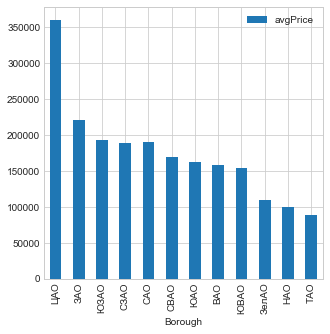

In [14]:
avg_estate_price_df = pd.read_csv('data/AvgBoroughPrice.csv')
avg_estate_price_df.columns = ['Borough', 'avgPrice']
avg_estate_price_df = avg_estate_price_df.set_index('Borough')
avg_estate_price_df.plot.bar(y='avgPrice', figsize=(5, 5))
plt.savefig('out/real_estate_price.png')

#### Get average rent price by borough

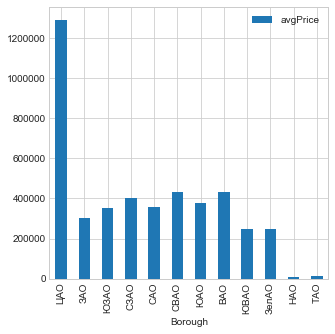

In [15]:
avg_rent_price = pd.read_csv('data/avgRentPrice.csv')
avg_rent_price.columns = ['Borough','avgPrice']
avg_rent_price = avg_rent_price.set_index('Borough')
avg_rent_price.plot.bar(y='avgPrice', figsize=(5, 5))
plt.savefig('out/average_rent_price_by_borough.png')

#### Average mounthly income was collected my company (according to official Federal State of statistics).  
It has so difficult calculation (including statictic by regestered model of cars etc.). In this section is displayed only result

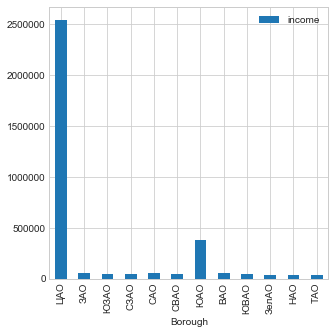

In [16]:
avg_income = pd.read_csv('data/avgIncome.csv')
avg_income.columns = ['Borough', 'income']
avg_income = avg_income.set_index('Borough')
avg_income.plot.bar(y='income', figsize=(5, 5))
plt.savefig('out/mounthly_income.png')

#### Get nearby places  by Foursquare

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        jdata = requests.get(url).json()
        try:
            results = jdata["response"]['groups'][0]['items']
        except:
            continue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    return(nearby_venues)

if file already exists read from local file

In [18]:
file_name = 'data/foursquare_data.json'
one = df_districts_coords
radius = 500 
LIMIT = 100
if not os.path.exists(file_name):
    print('collection data....')
    res = getNearbyVenues(one['DistrictName'], one['lat'],one['lng'], radius = radius, LIMIT = LIMIT)
    res.to_json(file_name)
else:
    print('file exists')
    with io.open(file_name, 'r', encoding='utf8') as json_file:
        res = pd.DataFrame(json.loads(json_file.read()))

file exists


In [19]:
res.columns = ['DistrictName', 'lan', 'lng', 'PlaceName', 'lan1', 'lng1', 'PlaceType']
foursquare_df = res[['DistrictName', 'lan', 'lng', 'PlaceName', 'PlaceType']]
foursquare_df.head()

,DistrictName,lan,lng,PlaceName,PlaceType
0,Академический,55.688005,37.572684,Billy McDaniel,Pub
1,Академический,55.688005,37.572684,Здоров.ру,Pharmacy
10,Академический,55.688005,37.572684,Суши Wok,Sushi Restaurant
100,Арбат,55.751138,37.590003,Тирольские пироги,Dessert Shop
1000,Марфино,55.830002,37.588745,ENJOY,Bakery


#### Get the nearest beer shops (by Yandex)

if file already exists read it from disk

In [20]:
file_name = 'data/json_geo_venues.json'
if not os.path.exists(file_name):
    print('collection data....')
    coords = []
    for d_name in df_districts_coords.iterrows():
        name = d_name[1].DistrictName
        lat = d_name[1].lat
        lng = d_name[1].lng
        tcount = d_name[1].ResTotalCount
        url = 'https://search-maps.yandex.ru/v1/?text=Магазин%20пива&ll={},{}&lang=ru_RU&spn=0.03,0.03&apikey={}'.format(
            lng,
            lat,
            y_api_1
            )
        resp = requests.get(url)
        resp.encoding = 'utf-8'
        jpayload = json.loads(resp.text)
        coords.append({name:{'data':jpayload}})
    with io.open(file_name, 'w', encoding='utf8') as json_file:
        json.dump(coords, json_file, ensure_ascii=False)
else:
    print('file exists')
    with io.open(file_name, 'r', encoding='utf8') as json_file:
        coords = json.loads(json_file.read())

file exists


#### Get beer shops by places

In [21]:
beer_shops = []
for item in coords:
    for key,val in item.items():
        for shop in val['data']['features']:
            shop_name = shop['properties']['name']
            beer_shops.append([key, shop_name])
beer_shops_df  = pd.DataFrame(beer_shops)
beer_shops_df.columns = ['DistrictName', 'BeerShop']
beer_shops_df.head()

,DistrictName,BeerShop
0,Академический,Munchies Pizza and Bierra
1,Академический,Вайн&Крафт
2,Академический,Бочка Шоп
3,Академический,Старый Мюнхен
4,Академический,Магазин Солод


#### Get total places (exclude beer shops)

In [22]:
foursquare_no_shops_df = foursquare_df[~foursquare_df['PlaceName'].isin(beer_shops_df['BeerShop'])]
total_amus_places_df = foursquare_no_shops_df.groupby(['DistrictName']).count().reset_index()
total_amus_places_df = total_amus_places_df[['DistrictName', 'lan']]
total_amus_places_df.columns = ['DistrictName', 'TotoalAmusPlaces']

#### Get total trademarks by places (Custormer decided to choose only these trademarks)

In [23]:
trademarks_df = pd.read_csv('data/Franchises.csv', delimiter =';')
beer_already_shops_df = beer_shops_df[beer_shops_df['BeerShop'].isin(trademarks_df['RussianName'])].reset_index()


#### Get districts where trademarks is already present

In [24]:
beer_already_shops_df['already'] =  pd.DataFrame(np.ones(beer_already_shops_df.shape[0]).astype(int))
beer_already_shops_df = beer_already_shops_df[['DistrictName', 'already']]

#### Set NEW Feature (count of beer shops / max beer shop per district)

In [25]:
beer_shops_by_district_df = beer_shops_df.groupby('DistrictName').count().reset_index()
beer_shops_by_district_df.columns = ['DistrictName', 'TotalFillness']
beer_shops_by_district_df['TotalFillness'] = beer_shops_by_district_df['TotalFillness'] / \
    beer_shops_by_district_df['TotalFillness'].max()

### Merge all the data in one DataFrame

In [26]:
estate_price_df = estate_price_df.reset_index()
estate_price_df.columns = ['DistrictName', 'avgPrice']

In [27]:
final_data_df = pd.merge(df_districts_coords, beer_shops_by_district_df, on='DistrictName',  how='left')

Mark if already is the same beer shop in district

In [28]:
final_data_df = pd.merge(final_data_df, beer_already_shops_df, on='DistrictName', how='left')
final_data_df.fillna(0, inplace=True)
final_data_df['already'] = final_data_df['already'].astype(int)

Some districts does not has price value so we replace it by average value from avg_estate_price_df dataframe

In [29]:
df = pd.merge(final_data_df, avg_estate_price_df, on='Borough', how='left')
df = pd.merge(df, estate_price_df, on=['DistrictName'], how='left')
df['avgPrice'] = df['avgPrice_y'].where(df['avgPrice_y'].notna(),df['avgPrice_x'])
final_data_df = df[['DistrictName','ResTotalCount','Borough','lat','lng','TotalFillness','already','avgPrice']]

Add rent price

In [30]:
final_data_df = pd.merge(final_data_df, avg_rent_price, on='Borough', how='left', suffixes = ('', '_rent'))

Add ararage income by district

In [31]:
final_data_df = pd.merge(final_data_df, avg_income, on='Borough', how='left')

Add total count of interesting places

In [32]:
final_data_df = pd.merge(final_data_df, total_amus_places_df, on='DistrictName', how='left')
final_data_df['TotoalAmusPlaces'].fillna((final_data_df['TotoalAmusPlaces'].mean()), inplace=True)
final_data_df['TotoalAmusPlaces'] = final_data_df['TotoalAmusPlaces'].astype(int)

#### Print result table

In [33]:
final_data_df.head()

,DistrictName,ResTotalCount,Borough,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces
0,Академический,109231,ЮЗАО,55.688005,37.572684,1.0,0,259369.0,350000,45000,41
1,Алексеевский,80391,СВАО,55.812949,37.650163,1.0,0,236290.0,432333,45423,23
2,Алтуфьевский,57408,СВАО,55.879849,37.582278,1.0,0,173135.0,432333,45423,14
3,Арбат,35529,ЦАО,55.751138,37.590003,0.7,0,709761.0,1293088,2540000,100
4,Аэропорт,79294,САО,55.803312,37.542599,1.0,0,253142.0,357444,55744,12


## Methodology <a name="methodology"></a>

In this section we already have corrected and cleared data.  
We have
- Total count of residents in district
- "Total fillness" - how many beer shops in district
- 1/0 if district has the same type of beer shop as customer selected
- Average real estate price (by square meter)
- Average rent price
- Avarage residents monthly income 
- Total count of interesting places in district  

By this information we can separeate the districts by special groups.   
We will use **K-means algorithm**. It's suitable for this task. After splitting our districts by groups we'll explore them. This exploreation will help us to detect economic situation in each district. By summany analisys we'll make decision what the best district is.

#### Detect clusters of districts

Select nessesary columns

In [34]:
data_df = final_data_df[['ResTotalCount', 'TotalFillness', 'already', 'avgPrice', \
    'avgPrice_rent', 'income', 'TotoalAmusPlaces']]

Number of clusters = 5

In [35]:
kclusters = 5
# run k-means algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_df)
klabels = kmeans.labels_

Apply cluster to the whole DataFrame

In [36]:
final_data_df['cluster'] = klabels

#### Plot cluster map and customer house place

In [37]:
msk_lat = 55.755814
msk_lng = 37.617635
map_clusters = folium.Map(location=[msk_lat, msk_lng], zoom_start=9)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(final_data_df['lat'], final_data_df['lng'], final_data_df['DistrictName'], \
                                  final_data_df['cluster'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# custormer house point
cust_lat = 55.664843
cust_lng = 37.766175     
folium.Marker(
    [cust_lat, cust_lng],
    popup='Customer House',
    icon=folium.Icon(color='green', icon='info-sign')
).add_to(map_clusters)

map_clusters

Save map to out directory

In [38]:
map_clusters.save("out/moscow_map_clusters.html")

## Analysis <a name="analysis"></a>

### Cluster analisis

##### Cluster N0

In [39]:
final_data_df[final_data_df['cluster']==0].describe()

,ResTotalCount,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces,cluster
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0
mean,96797.239130,55.739284,37.534832,0.943478,0.065217,230026.673913,299996.543478,49548.695652,19.108696,0.0
std,48213.287435,0.102966,0.178360,0.125879,0.249637,80288.776916,44340.296835,8260.145253,14.841725,0.0
min,25406.000000,55.610845,37.168244,0.500000,0.000000,128995.000000,249234.000000,34234.000000,2.000000,0.0
25%,64150.500000,55.676586,37.453538,1.000000,0.000000,166676.000000,250010.000000,45000.000000,9.000000,0.0
50%,87222.500000,55.708034,37.531914,1.000000,0.000000,218910.500000,300111.000000,45235.000000,13.500000,0.0
75%,124467.250000,55.777515,37.652155,1.000000,0.000000,270387.500000,350000.000000,59234.000000,25.750000,0.0
max,253908.000000,56.005103,37.928704,1.000000,1.000000,422163.000000,357444.000000,59234.000000,61.000000,0.0


This cluster has middle range income, middle range rent price and the same shops are almost absent. "Already" mean (0.06) (total ratio of selected trademarks) is low.

##### Cluster N1

In [40]:
final_data_df[final_data_df['cluster']==1].describe()

,ResTotalCount,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces,cluster
count,10.000000,10.000000,10.000000,10.000000,10.0,10.00000,10.0,10.0,10.000000,10.0
mean,77588.100000,55.754356,37.619726,0.840000,0.0,549859.10000,1293088.0,2540000.0,51.400000,1.0
std,36748.215571,0.019757,0.037888,0.157762,0.0,142808.52178,0.0,0.0,26.319406,0.0
min,27589.000000,55.729199,37.562389,0.600000,0.0,368747.00000,1293088.0,2540000.0,18.000000,1.0
25%,51059.750000,55.735620,37.594232,0.700000,0.0,446935.25000,1293088.0,2540000.0,32.250000,1.0
50%,69137.500000,55.757285,37.618183,0.850000,0.0,526768.50000,1293088.0,2540000.0,53.000000,1.0
75%,109801.000000,55.769237,37.649503,1.000000,0.0,670050.75000,1293088.0,2540000.0,67.750000,1.0
max,127462.000000,55.780066,37.671229,1.000000,0.0,778434.00000,1293088.0,2540000.0,100.000000,1.0


This cluster represents extremely rich people. Rent price is too high and this cluster has a lot of bars/restaurants.

##### Cluster N2

In [41]:
final_data_df[final_data_df['cluster']==2].describe()

,ResTotalCount,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces,cluster
count,16.00000,16.000000,16.000000,16.00000,16.000000,16.000000,16.0,16.0,16.000000,16.0
mean,111583.93750,55.636880,37.662548,0.96250,0.125000,193470.437500,379344.0,379344.0,17.812500,2.0
std,29451.22899,0.037606,0.052372,0.10247,0.341565,54248.113951,0.0,0.0,17.298242,0.0
min,51829.00000,55.587860,37.600361,0.70000,0.000000,140813.000000,379344.0,379344.0,4.000000,2.0
25%,87009.75000,55.611476,37.617660,1.00000,0.000000,166422.000000,379344.0,379344.0,9.000000,2.0
50%,115602.00000,55.629796,37.647769,1.00000,0.000000,181235.000000,379344.0,379344.0,11.500000,2.0
75%,132218.50000,55.666350,37.687380,1.00000,0.000000,196348.750000,379344.0,379344.0,17.250000,2.0
max,154191.00000,55.706457,37.765058,1.00000,1.000000,368260.000000,379344.0,379344.0,73.000000,2.0


This cluster has lower income and higher rent price then cluster №0

##### Cluster N3

In [42]:
final_data_df[final_data_df['cluster']==3].describe()

,ResTotalCount,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces,cluster
count,21.000000,21.000000,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000,21.0
mean,17090.333333,55.487388,37.269420,0.819048,0.0,94114.476190,10952.380952,35561.380952,9.142857,3.0
std,17412.188950,0.092045,0.160631,0.256162,0.0,5953.377551,1023.532631,3479.499181,7.485224,0.0
min,3408.000000,55.314208,36.883460,0.200000,0.0,88021.000000,10000.000000,32000.000000,1.000000,3.0
25%,6849.000000,55.421496,37.208273,0.800000,0.0,88021.000000,10000.000000,32000.000000,2.000000,3.0
50%,8869.000000,55.481546,37.295014,0.900000,0.0,99654.000000,10000.000000,38799.000000,6.000000,3.0
75%,20104.000000,55.570014,37.366610,1.000000,0.0,99654.000000,12000.000000,38799.000000,18.000000,3.0
max,60924.000000,55.633500,37.567653,1.000000,0.0,99654.000000,12000.000000,38799.000000,18.000000,3.0


This cluster has th lowest rent price and income. There are not the selected trademarks in this cluster. There are not too many bars/restaurants.

##### Cluster N4

In [43]:
final_data_df[final_data_df['cluster']==4].describe()

,ResTotalCount,lat,lng,TotalFillness,already,avgPrice,avgPrice_rent,income,TotoalAmusPlaces,cluster
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0
mean,96861.773585,55.817456,37.619239,0.950943,0.113208,190702.981132,410766.509434,48370.849057,15.396226,4.0
std,45746.422063,0.078135,0.138261,0.117051,0.319878,36104.712175,32244.777143,5268.919468,9.632357,0.0
min,9903.000000,55.542396,37.365828,0.500000,0.000000,121769.000000,350000.000000,40100.000000,1.000000,4.0
25%,67367.000000,55.796931,37.528630,1.000000,0.000000,169747.000000,401000.000000,45423.000000,8.000000,4.0
50%,90017.000000,55.824162,37.607700,1.000000,0.000000,182769.000000,432333.000000,45423.000000,13.000000,4.0
75%,110272.000000,55.869041,37.722487,1.000000,0.000000,198860.000000,434123.000000,52123.000000,21.000000,4.0
max,207967.000000,55.936812,37.866235,1.000000,1.000000,296832.000000,434123.000000,55744.000000,42.000000,4.0


This cluster has approximately the same income as cluster №0 but rent price is higher. "TotalFillness" parameter is too hight (amount of bars/pub etc.).

## Results and Discussion<a name="results"></a>

take a bank loan  
there is high competition

## Conclusion<a name="conclusion"></a>

<img src="out/cust_house.png" style="width: 500px;">